In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Conv1D,Add,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2
import pandas as pd
from tqdm.auto import tqdm
import os
import natsort
from glob import glob
import numpy as np
import warnings
import json

warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices, 'GPU')

In [4]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # GPU 사용 가능
    for gpu in gpus:
        print("GPU:", gpu)
else:
    # GPU 사용 불가능
    print("GPU not found")

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 멀티모달 model train 

<AxesSubplot: >

  0%|          | 0/2193 [00:00<?, ?it/s]

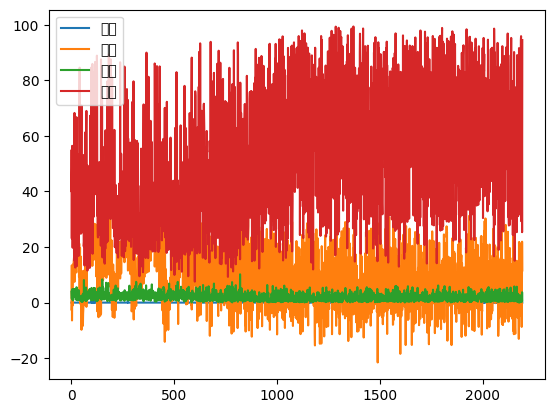

In [5]:
image_size=24

path='new_train'
#path='prev_train'

height_train=np.load(f'D:/{path}{image_size}/Height_train.npy')
ndvi_train=np.load(f'D:/{path}{image_size}/NDVI_train.npy')
slope_train=np.load(f'D:/{path}{image_size}/Slope_train.npy')
landuse_train=np.load(f'D:/{path}{image_size}/Landuse_train.npy')
popden_train=np.load(f'D:/{path}{image_size}/Pop_train.npy')
forest_train=np.load(f'D:/{path}{image_size}/Forest_train.npy')

tabular_data=pd.read_csv(f"D:/{path}{image_size}/Weather_data.csv",encoding='cp949')
tabular_data.drop(['lon', 'lat'],axis=1,inplace=True)
tabular_data=tabular_data.replace(32767.0,-9999)
#tabular_data=tabular_data.replace(-9999.0,0)
tabular_data[['강수','기온','풍속','습도']].plot()
x,y=[],[]
for j in tqdm(range(len(tabular_data))):
    x.append(np.array(tabular_data.loc[j, ['습도', '강수', '기온', '풍속']]).astype(float))

    y.append(np.array(tabular_data.loc[j, ['target']]).astype(float))
climate = np.array(x)
y = np.array(y)

In [6]:
height_input = Input(shape=(image_size, image_size, 3), name='height_input')
ndvi_input = Input(shape=(image_size, image_size, 3), name='ndvi_input')
slope_input = Input(shape=(image_size, image_size, 3), name='slope_input')
landuse_input = Input(shape=(image_size, image_size, 3), name='landuse_input')
popden_input = Input(shape=(image_size, image_size, 3), name='popden_input')
forest_input = Input(shape=(image_size, image_size, 3), name='forest_input')
climate_input = Input(shape=(4,1), name='climate_input')

def residual_block(input_layer, filters, kernel_size):
    x = Conv2D(filters, kernel_size, padding='same')(input_layer)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    
    if input_layer.shape[-1] != filters:
        input_layer = Conv2D(filters, (1, 1), padding='same')(input_layer)
    
    x = Add()([input_layer, x])
    x = Activation('relu')(x)
    return x

def res_layers(input_layer):
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(input_layer)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
    
    x = residual_block(x, 64, (3, 3))
    x = residual_block(x, 64, (3, 3))
    
    x = residual_block(x, 128, (3, 3))
    x = residual_block(x, 128, (3, 3))
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    return x

def cnn_layers(input_layer):
    conv1_im = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
    pool1_im = MaxPooling2D(pool_size=(2,2))(conv1_im)
    
    conv2 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(pool1_im)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    conv4 = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
    
    flatten = Flatten()(pool3)
    
    dense1 = Dense(128, activation='relu')(flatten)
    
    return dense1


def dense_layer(input_layer):
    dense0 = Dense(64, activation='relu')(input_layer)
    dense1 = Dense(64, activation='relu')(dense0)
    flatten = Flatten()(dense1)
    dense2 = Dense(64, activation='relu')(flatten)
    return dense2
    
height_cnn = cnn_layers(height_input)
ndvi_cnn = cnn_layers(ndvi_input)
slope_cnn = cnn_layers(slope_input)
landuse_cnn = cnn_layers(landuse_input)
popden_cnn = cnn_layers(popden_input)
forest_cnn = cnn_layers(forest_input)
climate_cnn = dense_layer(climate_input)

#merged = concatenate([height_cnn, ndvi_cnn, slope_cnn, landuse_cnn, popden_cnn,forest_cnn, climate_cnn])
#merged = concatenate([height_cnn, ndvi_cnn, slope_cnn, landuse_cnn, popden_cnn, climate_cnn])
#merged = concatenate([climate_cnn])
merged=climate_cnn

output_layer = Dense(1, activation='sigmoid', name='output_layer')(merged)

#model = Model(inputs=[height_input, ndvi_input,slope_input,landuse_input,popden_input,climate_input], outputs=output_layer)
#model = Model(inputs=[height_input, ndvi_input,slope_input,climate_input], outputs=output_layer)
model = Model(inputs=[climate_input], outputs=output_layer)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 climate_input (InputLayer)  [(None, 4, 1)]            0         
                                                                 
 dense_6 (Dense)             (None, 4, 64)             128       
                                                                 
 dense_7 (Dense)             (None, 4, 64)             4160      
                                                                 
 flatten_6 (Flatten)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 20,801
Trainable params: 20,801
Non-trainable p

In [7]:
x_train = {
    #'height_input': height_train,
    #'ndvi_input': ndvi_train,
    #'slope_input': slope_train,
    #'landuse_input': landuse_train,
    #'popden_input': popden_train,
    #'forest_input': forest_train,
    'climate_input':climate
}

In [8]:
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.95:
            print("Reached accuracy threshold (0.9). Stopping training.")
            self.model.stop_training = True
model.fit(x_train, y, epochs=100, batch_size=256, callbacks=[AccuracyThresholdCallback()])

Epoch 1/100
9/9 [==============================] - 1s 5ms/step - loss: 0.7994 - accuracy: 0.3899
Epoch 2/100
9/9 [==============================] - 0s 4ms/step - loss: 0.6648 - accuracy: 0.5837
Epoch 3/100
9/9 [==============================] - 0s 5ms/step - loss: 0.6265 - accuracy: 0.6484
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 0.6027 - accuracy: 0.6794
Epoch 5/100
9/9 [==============================] - 0s 5ms/step - loss: 0.5955 - accuracy: 0.6808
Epoch 6/100
9/9 [==============================] - 0s 3ms/step - loss: 0.5921 - accuracy: 0.6817
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 0.5908 - accuracy: 0.6840
Epoch 8/100
9/9 [==============================] - 0s 3ms/step - loss: 0.5896 - accuracy: 0.6840
Epoch 9/100
9/9 [==============================] - 0s 3ms/step - loss: 0.5891 - accuracy: 0.6845
Epoch 10/100
9/9 [==============================] - 0s 3ms/step - loss: 0.5879 - accuracy: 0.6849
Epoch 11/100
9/9 [===========

In [9]:
#model.save(f"C:/Users/user/fire_model/{path}{image_size}/cnn") 
model.save(f"C:/Users/user/fire_model/try/cnn4onlyclimate") 

INFO:tensorflow:Assets written to: C:/Users/user/fire_model/try/cnn4onlyclimate\assets


In [80]:
y_pred = model.predict(x_test)
y_pred

13/13 [==============================] - 0s 24ms/step


array([[0.9511119 ],
       [0.6638504 ],
       [0.9243032 ],
       [0.36866847],
       [0.96533704],
       [0.50629115],
       [0.894358  ],
       [0.7636744 ],
       [0.99814063],
       [0.5209027 ],
       [0.9760125 ],
       [0.9424071 ],
       [0.9863269 ],
       [0.935752  ],
       [0.92519057],
       [0.67485106],
       [0.98790586],
       [0.9989828 ],
       [0.99818   ],
       [0.9968638 ],
       [0.98516494],
       [0.9779872 ],
       [0.9956075 ],
       [0.7364466 ],
       [0.93447095],
       [0.6338504 ],
       [0.97422516],
       [0.9690676 ],
       [0.77703154],
       [0.9968832 ],
       [0.7898568 ],
       [0.91756684],
       [0.99230975],
       [0.7502356 ],
       [0.9647244 ],
       [0.99972296],
       [0.9894323 ],
       [0.9992107 ],
       [0.8908258 ],
       [0.9659373 ],
       [0.7065911 ],
       [0.9215959 ],
       [0.8963555 ],
       [0.8801547 ],
       [0.99681   ],
       [0.99954003],
       [0.8433061 ],
       [0.938

In [81]:
#forest_input = Input(shape=(32, 32, 3), name='forest_input')
height_input = Input(shape=(image_size, image_size, 3), name='height_input')
ndvi_input = Input(shape=(image_size, image_size, 3), name='ndvi_input')
slope_input = Input(shape=(image_size, image_size, 3), name='slope_input')
landuse_input = Input(shape=(image_size, image_size, 3), name='landuse_input')
popden_input = Input(shape=(image_size, image_size, 3), name='popden_input')
forest_input = Input(shape=(image_size, image_size, 3), name='forest_input')
climate_input = Input(shape=(4,1), name='climate_input')

def residual_block(input_layer, filters, kernel_size):
    x = Conv2D(filters, kernel_size, padding='same')(input_layer)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    
    if input_layer.shape[-1] != filters:
        input_layer = Conv2D(filters, (1, 1), padding='same')(input_layer)
    
    x = Add()([input_layer, x])
    x = Activation('relu')(x)
    return x

def res_layers(input_layer):
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(input_layer)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
    
    x = residual_block(x, 64, (3, 3))
    x = residual_block(x, 64, (3, 3))
    
    x = residual_block(x, 128, (3, 3))
    x = residual_block(x, 128, (3, 3))
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    return x

def cnn_layers(input_layer):
    conv1_im = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
    pool1_im = MaxPooling2D(pool_size=(2,2))(conv1_im)
    
    conv2 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(pool1_im)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    flatten = Flatten()(pool3)
    
    dense1 = Dense(128, activation='relu')(flatten)
    
    return dense1


def dense_layer(input_layer):
    dense0 = Dense(64, activation='relu')(input_layer)
    dense1 = Dense(64, activation='relu')(dense0)
    flatten = Flatten()(dense1)
    dense2 = Dense(64, activation='relu')(flatten)
    return dense2
    
#forest_cnn = cnn_layers(forest_input)
height_cnn = cnn_layers(height_input)
ndvi_cnn = cnn_layers(ndvi_input)
slope_cnn = cnn_layers(slope_input)
landuse_cnn = cnn_layers(landuse_input)
popden_cnn = cnn_layers(popden_input)
forest_cnn = cnn_layers(forest_input)
climate_cnn = dense_layer(climate_input)

merged = concatenate([height_cnn, ndvi_cnn, slope_cnn, landuse_cnn, popden_cnn,forest_cnn, climate_cnn])

output_layer = Dense(1, activation='sigmoid', name='output_layer')(merged)

model = Model(inputs=[height_input, ndvi_input,slope_input,landuse_input,popden_input,forest_input,climate_input], outputs=output_layer)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

378